Modelo de clasificación de imágenes con transferencia de aprendizaje
====================================================================

## Introducción

La clasificación de objetos es la tarea por la cual un modelo de aprendizaje automático asigna una o varias etiquetas a diferentes imágenes dependiendo del contenido de la misma. Esta tarea se volvió muy popular en 2012 en el contexto de aprendizaje automático ya que fué la primera tarea en alcanzar una performance sustancialmente mayor que con técnicas clásicas. En esta ocación utilizaremos un modelo basado en Transfer Learning el cual operará como extractor de features para nuestro modelo.

### Preparación del ambiente

Intalamos las librerias necesarias

In [ ]:
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/docs/vision/tasks/classification/code/cnn_class_transfer_learning.txt \
    --quiet --no-clobber
!pip install -r cnn_class_transfer_learning.txt --quiet

### Sobre el conjunto de datos de este ejemplo

Para ejemplificar esta técnica utilizaremos un conjunto de datos muy popular llamado CIFAR-10. CIFAR-10 es un conjunto de datos que consiste en 60.000 imagenes a color de 32x32 agrupadas en 10 clases, con 6000 imagenes cada una. Hay alrededor de 50000 imagenes para entrenamiento y 10000 para testing.

Las categorias son:
 - airplane
 - automobile
 - bird
 - cat
 - deer
 - dog
 - frog
 - horse
 - ship
 - truck

Podemos cargar este conjunto de datos facilmente utilizando `tensorflow-datasets`:

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds

ds, info = tfds.load('cifar10', split='train', shuffle_files=True, with_info=True)

In [ ]:
print("Numero de clases: ", info.features["label"].num_classes)
print("Clases disponibles: ", info.features["label"].names)

Numero de clases:  10
Clases disponibles:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Veamos algunos ejemplos:

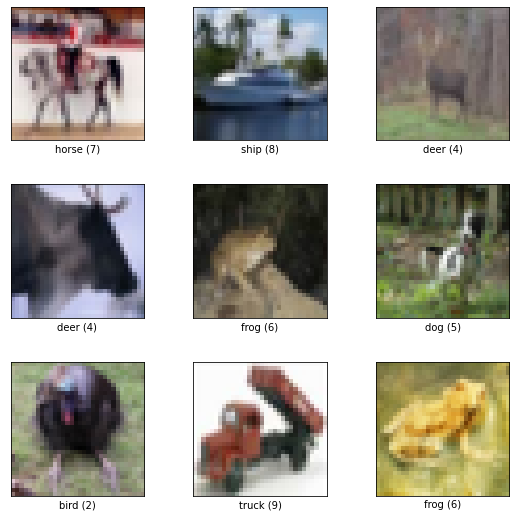

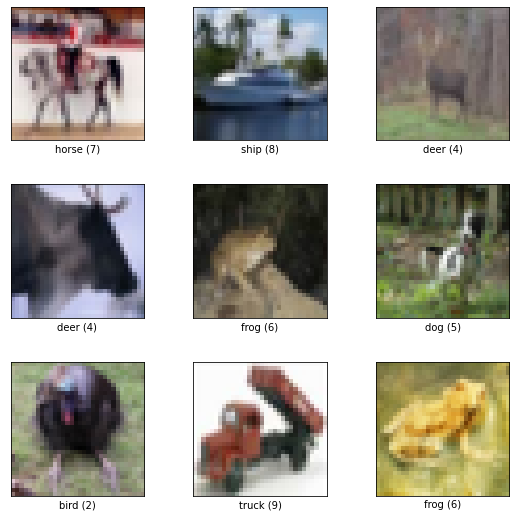

In [ ]:
tfds.show_examples(ds, info)

## Utilizando transferencia de aprendizaje en nuestro modelo

### ¿Qué es TensorFlow Hub?

Un concepto que es esencial en el desarrollo de software es la idea de reutilizar el código que está disponible a través de librerías. Las librerías hacen que el desarrollo sea más rápido y generan más eficiencia. Para los cientificos de datos que trabajan en visión artificial, entrenar arquitecturas de redes neuronales complejas desde cero resulta altamente complejo. TensorFlow Hub es una biblioteca que permite publicar y reutilizar componentes de aprendizaje automático prediseñados. Con TF.Hub, resulta sencillo volver a entrenar la capa superior de un modelo previamente entrenado para reconocer las clases en un nuevo conjunto de datos. TensorFlow Hub también distribuye modelos sin la capa de clasificación. Estos se pueden utilizar para realizar fácilmente el aprendizaje por transferencia. Puede descargar cualquier [modelo para imágenes compatible con Tensorflow 2 de tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2). La única condición es asegurarse de que la forma de las características de la imagen en nuestro conjunto de datos preparado coincida con la forma de entrada esperada del modelo que desea reutilizar.

### Antes de comenzar

Antes de comenzar necesitaremos verificar que tenemos el runtime correcto en nuestro ambiente. Esta tarea se beneficiará mucho de una GPU.

In [ ]:
import tensorflow as tf
print("GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))

GPUs disponibles:  1


Adicionalmente, configuraremos nuestro conjunto de datos para una tarea supervisada. Esto lo hacemos especificando el parametro *as_supervised=True* lo cual nos da la posibilidad de acceder a las anotaciones del conjunto de datos.

In [ ]:
(training_set, validation_set) = tfds.load('cifar10', split=['train[:10%]', 'test[:10%]'], as_supervised=True)

### Ajustando el tamaño de nuestras imagenes

El modelo que utilizaremos más adelante será ResNet. Veremos más en detalle este modelo luego, pero lo importante aquí es que es un modelo que se entrenó utilizando imagenes de tamaño 224x224.

In [ ]:
import tensorflow_hub as hub

model_url = "https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/3"
module_spec = hub.load_module_spec(model_url)
img_height, img_width = hub.get_expected_image_size(module_spec)

print("El tamaño esperado de imagenes es:", img_height, "x", img_width)

El tamaño esperado de imagenes es: 224 x 224


> *Nota: Alternativamente a utilizar código para averiguar las propiedades de la imagen, puede directamente dirijirse a la página de TensorFlow Hub y verificar la documentación del modelo que está utilizando.*

Sin embargo, nuestras imagenes podrían no tener este tamaño e incluso podrían no tener el mismo tamañao. ¿Como hacemos para ajustar el tamaño? En general existen 2 técnicasÑ

#### Padding

Podemos utilizar una una técnica similar a cuando ajustamos la longitud de las secuencias en NLP, **Padding**. Padding agregará ceros en en la imagen hasta completar el tamaño especificado:

<img src="https://th.bing.com/th/id/OIP.8D8BXN3aHLCyTNTE2GssmQAAAA?pid=Api&rs=1" />

En TensorFlow, esto lo podemos realizar utilizando el metodo `padded_batch` el cual agrupa las imagenes en batches para entrenamiento y al mismo tiempo ajusta el tamaño de los tensores al necesitado:

In [ ]:
BATCH_SIZE=64
EPOCHS = 3

training_set_batch = training_set.padded_batch(batch_size=BATCH_SIZE, padded_shapes=([224, 224, 3], [])).cache().repeat()
validation_set_batch = validation_set.padded_batch(batch_size=BATCH_SIZE, padded_shapes=([224, 224, 3], [])).cache().repeat()
train_size = info.splits['train[:10%]'].num_examples
test_size = info.splits['test[:10%]'].num_examples

> **Imporante:** Notará que en este ejemplo estaremos utilizando el 10% del conjunto de entrenamiento. El motivo de esto es simplemente para reducir el tiempo de entrenamiento del modelo. ResNet es un modelo computacionalmente costoso y por lo tanto requeriremos de bastante hardware para ejecutarlo. Más adelante utilizaremos un modelo con menos performance pero conmucho menos requerimientos de cómputo.

#### Resizing

Otra alternativa es cambiar el tamaño de las imagenes hasta que alcanzen el tamaño que necesitamos. Cuando las imágenes que trabajamos son más grandes que las que nuestro modelo opera, en general utilizamos esta técnica. Esto se puede realizar o bien como parte del preprocesamiento o como parte de la red utilizando una capa de reescalado. En este notebook utilizaremos esta técnica más adelante.

```
        tf.keras.layers.Resizing(
            244, 244, interpolation="bilinear", crop_to_aspect_ratio=False
        ),
```

### Construimos un modelo basado en ResNet50

Construiremos nuestro modelo basado en ResNet50. ResNet-50 es una CNN de 50 capas de profundidad que utiliza el concepto de skip-connection, de una forma similar a la que se utiliza por el sistema de visión humano. Esta implementación le permite a la red reutilizar las activaciones de capas anteriores y asi no solo mapear conceptos que se aprendieron en otra jerarquia de la red sino que también evitar el problema de desaparición de los gradientes.

Instanciamos nuestro modelo y verificamos su arquitectura

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental import preprocessing

model = keras.models.Sequential([
    tf.keras.layers.Resizing(244, 244, interpolation="bilinear", crop_to_aspect_ratio=False, input_shape=(None, None, 3)),
    tf.keras.layers.Rescaling(1 / 255.0),
    hub.KerasLayer(model_url, trainable=False),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 244, 244, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 244, 244, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23561152  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 23,824,714
Trainable params: 263,562
Non-trainable params: 23,561,152
_________________________________________________________________


#### ¿Porque hay una capa de `Rescaling`?

Las imágenes de entrada están codificadas como arreglos de pixeles que contienen la luminosidad en cada uno de los canales. Esta luminosidad puede ir desde 0 hasta 255. Sin embargo, `RestNet` fue entrenado utilizando imágenes que fueron normalizadas. Es decir, cuyos valores están entre `[0, 1]`. Como regla, debera siempre aplicar el mismo preprocesamiento que el modelo realizó originalmente sobre los datos de entrada. Keras dispone de una capa que nos permite realizar esto.

```
preprocessing.Rescaling(scale=1./255.)
```

Comenzamos el entrenamiento

In [ ]:
history = model.fit(training_set_batch,
                    epochs=EPOCHS,
                    steps_per_epoch=train_size,
                    validation_data=validation_set_batch,
                    validation_steps=test_size)

Epoch 1/3
5000/5000 [==============================] - 1096s 218ms/step - loss: 0.6778 - accuracy: 0.7774 - val_loss: 2.3578 - val_accuracy: 0.4983
Epoch 2/3
5000/5000 [==============================] - 1086s 217ms/step - loss: 0.2252 - accuracy: 0.9309 - val_loss: 3.1855 - val_accuracy: 0.4962
Epoch 3/3
5000/5000 [==============================] - 1086s 217ms/step - loss: 0.1096 - accuracy: 0.9670 - val_loss: 4.0146 - val_accuracy: 0.5051


> Dado que estamos utilizando un objeto de tipo `tf.Dataset` como argumento de `validation_data` de `Model.fit`, Keras no sabe por cuantos etapas hay que validar. Por este motivo el argumento `validation_steps` fue configurado.

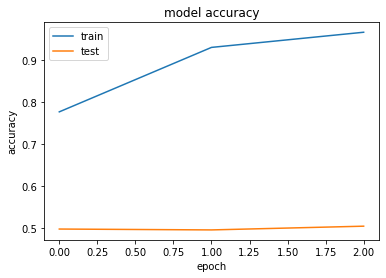

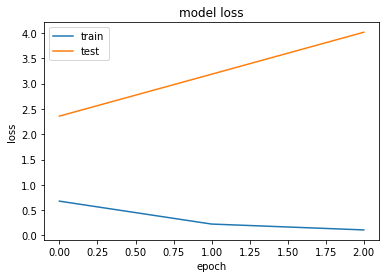

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

plot_history(history)

> ¿Que le parece que está sucediendo con este modelo? ¿Por que la pérformance del mismo no es la que esperamos?